Assume a uniform distribution for the decision variables, and randomly assign values. 

SHOW: any wind pattern except the instanton, having the same objective value as the instanton, must result in lower line temperature.

NEED: wind patterns that result in the same objective value as the instanton, on the same line. There should be a way to fix the decision variables and determine the resulting line temperature and objective value.

In [1]:
using Interact
using PyPlot
PyPlot.svg(true)

####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")
include("../src/LineThermalModel.jl")

using TemporalInstanton,TemporalInstanton2
using HDF5, JLD

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

Sb = 100e6 #overwrite "100.0"

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
#P0 = [0.5.*Rp,Rp,1.5*Rp]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
lines = [(f[i],t[i]) for i in 1:length(f)];
line_lengths = load("../data/RTS-96\ Data/line_lengths.jld", "line_lengths")

# Thermal model parameters:
Tamb = 35. # C
T0 = 46. # initial line steady-state temp
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# Create Qobj:
Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)

# Create A1 (only A2 changes during opt.):
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]

# Create b:
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)

# Create Qtheta:
Qtheta = tmp_inst_Qtheta(n,nr,T)

# Form objective quadratic:
G_of_x = (Qobj,0,kQobj)

println("loaded")

score,x,θ,α,diffs,xopt = loop_through_lines_new(
    G_of_x,Qtheta,A1,b,
n,T,Ridx,Sb,ref,lines,res,reac,line_lengths,Tamb,T0,int_length)
println("Unsolved lines: $(sum(score.==Inf))")

INFO: Loading help data...


loaded
Unsolved lines: 0


Slider{Int64}([Input{Int64}] 52,"eidx",52,1:104)

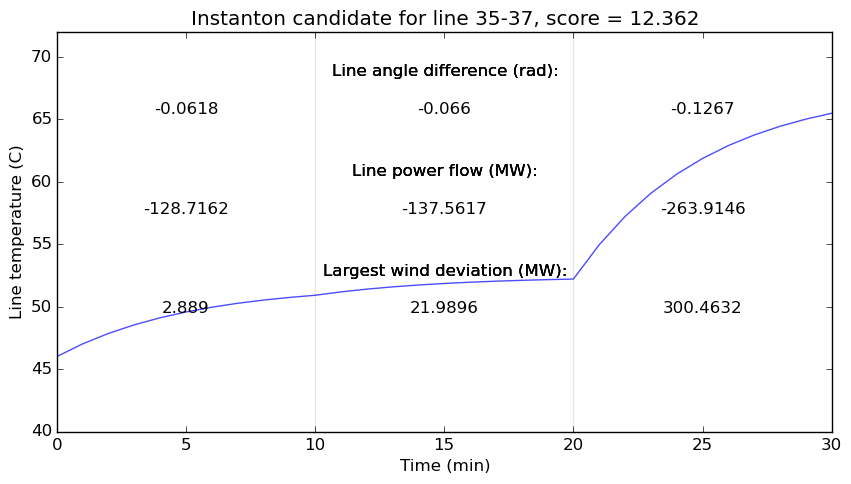

In [11]:
temp_eq(t,T0,a,b) = (T0 + b/therm_a).*exp(therm_a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow


fig = figure(figsize=(10,5))
@manipulate for eidx in 1:length(score); withfig(fig) do
        idx = find(score.==sort(score)[eidx])[1]
        from,to = lines[line_lengths.!=0][idx]
        r_ij = res[line_lengths.!=0][idx]
        x_ij = reac[line_lengths.!=0][idx]
        L_ij = line_lengths[line_lengths.!=0][idx]
        T0 = 46.

        angle_diffs = Float64[]
        for angles in θ[idx]
            push!(angle_diffs,angles[from] - angles[to])
        end

        # Tool to compute line temperature given initial temp and angle diffs:

        temp_values = [T0]
        power_flow = Float64[]
        
        for θij in angle_diffs
            f_loss_pu = r_ij*(θij/x_ij)^2 # pu
            f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
            push!(power_flow,(Sb/1e6)*θij/x_ij)
            b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
            temp_values = [temp_values,temp_eq(time_values,T0,therm_a,b)[2:end]]
            T0 = temp_values[end]
        end
        
        plot(temp_values,alpha=0.7)
        title("Instanton candidate for line $(from)-$(to), score = $(round(sort(score)[eidx],4))")
        xlabel("Time (min)")
        ylabel("Line temperature (C)")
        axis([0,30,40,1.1*Tlim])
        plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
        plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
        midpoints = [5,15,25]
        vrules = [Tlim+3,Tlim-5,Tlim-13]
        for i in 1:T
            text(15,vrules[1],"Line angle difference (rad):",
                horizontalalignment="center")
            text(midpoints[i],vrules[1]-3,string(round(angle_diffs[i],4)),
                horizontalalignment="center")
            text(15,vrules[2],"Line power flow (MW):",
                horizontalalignment="center")
            text(midpoints[i],vrules[2]-3,string(round(power_flow[i],4)),
                horizontalalignment="center")
            
            largest_dev = maxabs(x[idx][i])
            text(15,vrules[3],"Largest wind deviation (MW):",
                horizontalalignment="center")
            text(midpoints[i],vrules[3]-3,string(round(largest_dev*Sb/1e6,4)),
                horizontalalignment="center")
        end
    end
end

So I need variable values that result in 0.0003 objective, and I need to determine the resulting temperature of line 56-57 (line 91).

How do you find a family of vectors that have the same norm?

In [75]:
# Generate this many vectors:
numVecs = 25

vecs = Array(Vector,0)
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = rand(length(x[1][1])*T) - 0.5
    # Normalize to match min-score objective:
    traj = sqrt(minimum(score))*inter/norm(inter)
    push!(vecs,traj)
end
# Now vecs contains a family of vectors with the same
# norm.

In [76]:
# Check:
[norm(vecs[1]),norm([x[80][1],x[80][2],x[80][3]])]

2-element Array{Float64,1}:
 0.0161171
 0.0161171

Done. Now how do I find the line temperature resulting from these trajectories? I need to feed in the vector and perform a power flow.

Trace back through my code and isolate the $Ax=b$ part.

Solve for angles and mismatches given renewable generation vector.

In [2]:
# Expand renewable generation vector with zeros:
function expand_renewable_vector(x,Ridx,N,T)
    idx = Array(Integer,0)
    for i = 0:T-1
        append!(idx,Ridx + i*N)
    end
    P = zeros(N*T)
    P[idx] = x
    return P
end

function fixed_wind_A(T,Y,ref,k)
    """ Generate the power balance constraint A matrix
    from problem dimensions, admittance matrix,
    and generator participation factors.
    Assumes the admittance matrix is n-by-n.
    
    Returns A, which is (n+1)*T-by-(nr+n+1)*T
    
    * nr is the number of wind farms in the network
    * n is the number of nodes in the network
    * Ridx is a vector indicating wind farm locations
    * T is the number of time steps
    * Y is the admittance matrix (n-by-n)
    * ref is the index of the angle reference bus
    * k is the vector of generator participation factors
    """
    
    function ei(n,i)
        e = zeros(n)
        e[i] = 1.
        return e
    end
    
    n = size(Y,1)
    
    # A has a block diagonal pattern where each
    # block is Atemp:
    Atemp = sparse([[  Y       -k];
                    ei(n,ref)'   0])
    
    # Now we can tile the Atemp matrix to generate A:
    A = Atemp
    for t = 2:T
        A = blkdiag(A, Atemp)
    end
    
    return full(A)
end

function fixed_wind_b(n,T,G0,Pnet,D)
    """ Generate the vector b of power balance constraints.
    Assumes G0 and D are nT-by-1 vectors.
    """
    b = FloatingPoint[]
    netGen = G0 + Pnet - D

    for t = 1:T
        start = (t-1)*n + 1
        stop = start + n - 1
        append!(b,netGen[start:stop])
        push!(b,0.)
    end
    return b
end

function return_angles(fixed_x,N)
    angles = Array(Vector,0)
    alpha = FloatingPoint[]
    for i = 1:T
        push!(angles,fixed_x[(N+1)*(i-1)+1:(N+1)*(i-1)+N])
        push!(alpha,fixed_x[(N+1)*(i-1)+N+1])
    end
    return angles,alpha
end

function return_angle_diffs(angles,line)
    angle_diffs = FloatingPoint[]
    f = line[1]
    t = line[2]
    for v in angles
        push!(angle_diffs,v[f] - v[t])
    end
    return angle_diffs
end

return_angle_diffs (generic function with 1 method)

Slider{Float64}([Input{Float64}] 0.0,"el1",0.0,-0.05:0.001:0.05)

Slider{Int64}([Input{Int64}] 27,"plc",27,1:54)

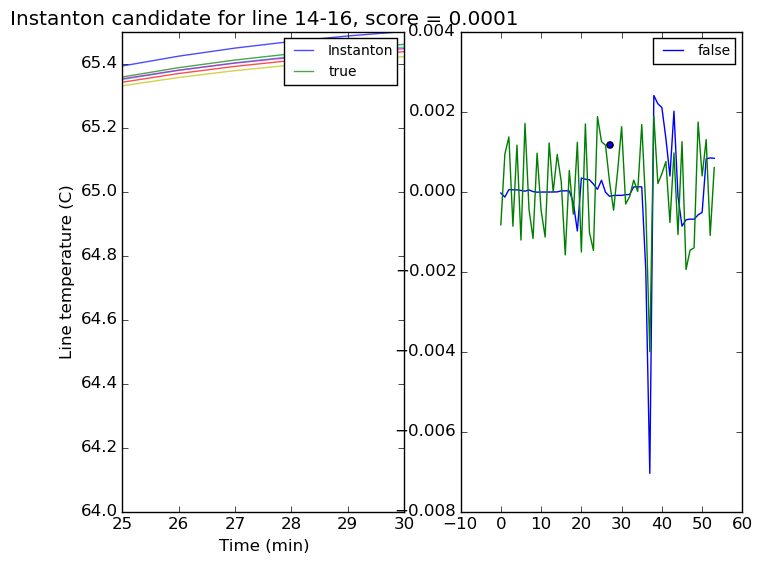

In [4]:
eidx = 1

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.5
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 5

vecs = Array(Vector,0)

# First vector is instanton analysis output:
push!(vecs,[x[idx][1],x[idx][2],x[idx][3]])
#push!(vecs,zeros(54))

for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*i/100
    #inter = zeros(size(vecs[1]))#rand(Nr*T) - 0.5
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end
# Now vecs contains a family of vectors with the same
# norm.
#vecs[2] = zeros(54)

angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)

fig = figure()
@manipulate for el1 in -0.05:0.001:0.05, plc in 1:54; withfig(fig) do
        #vecs[2][plc] = el1
        
temp_trajectories = Array(Vector,0)

for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)
    
    T0 = 46.
    temp_values = [T0]
    power_flow = Float64[]
    
#     if i == 1
#         fixed_diffs = [θ[idx][z][from] - θ[idx][z][to] for z in 1:T]
#     end
    
    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end

    push!(temp_trajectories,temp_values)
end

# Plot
        subplot(121)
for i in 1:size(temp_trajectories,1)
    plot(temp_trajectories[i],alpha=0.7)
end
title("Instanton candidate for line $(from)-$(to), score = $(round(sort(score)[eidx],4))")
xlabel("Time (min)")
ylabel("Line temperature (C)")
# axis([0,30,40,1.1*Tlim])
axis([25,30,64,65.5])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
midpoints = [5,15,25]
        legend(["Instanton","$(temp_trajectories[2][end]<=temp_trajectories[1][end])"],fontsize=10)
        
        subplot(122)
        plot(vecs[1])
        hold=true
        plot(vecs[2])
        scatter(plc,vecs[2][plc])
        legend(["$(norm(vecs[2])<norm(vecs[1]))"],fontsize=10)
    end
end
#savefig("../images/2015-06-17-random_higher.png")

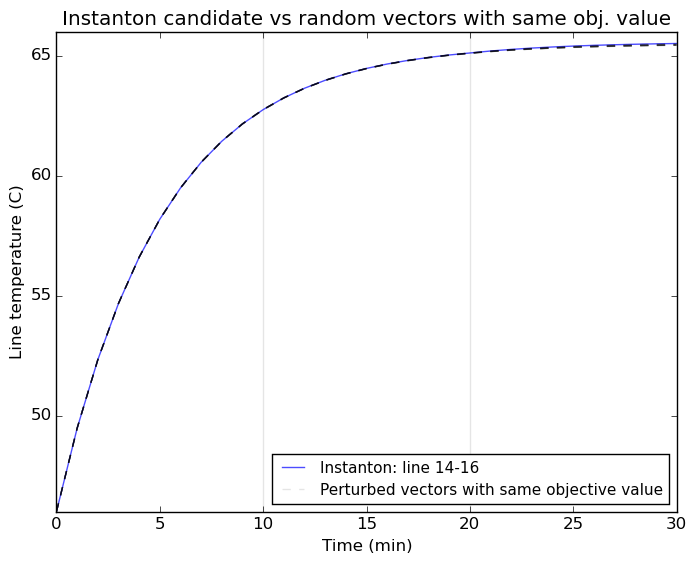

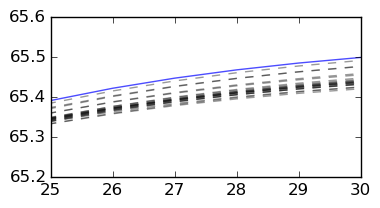

In [84]:
eidx = 1

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.5
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 20

vecs = Array(Vector,0)

# First vector is instanton analysis output:
push!(vecs,[x[idx][1],x[idx][2],x[idx][3]])
#push!(vecs,zeros(54))

for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*i/500
    #inter = zeros(size(vecs[1]))#rand(Nr*T) - 0.5
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end
# Now vecs contains a family of vectors with the same
# norm.

angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)

fig = figure(figsize=(8,6))

temp_trajectories = Array(Vector,0)

for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end

    push!(temp_trajectories,temp_values)
end

# Plot
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(temp_trajectories[i],alpha=0.7)
    else
        plot(temp_trajectories[i],alpha=0.1,"k--")
    end
end
title("Instanton candidate vs random vectors with same obj. value")
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)","Perturbed vectors with same objective value"],fontsize=11,loc=4)
# axis([0,30,40,1.1*Tlim])
axis([0,30,46,66])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
midpoints = [5,15,25]

savefig("../images/2015-06-18-inst-vs-rand.svg")

fig2 = figure(figsize=(4,2))
# Plot
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(temp_trajectories[i],alpha=0.7)
    else
        plot(temp_trajectories[i],alpha=0.4,"k--")
    end
end
#title("Instanton candidate vs random vectors with same obj. value")
#xlabel("Time (min)")
#ylabel("Line temperature (C)")
#legend(["Instanton: line $(from)-$(to)","Perturbed vectors with same objective value"],fontsize=11,loc=4)
# axis([0,30,40,1.1*Tlim])
axis([25,30,65.2,65.6])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
yticks(65.2:0.1:65.6)
midpoints = [5,15,25]

savefig("../images/2015-06-18-inst-vs-rand-zoom.svg")


## What is going wrong?

I am getting the opposite of what I expected. The instanton should be the least-min vector that causes the line to reach its maximum temperature. Every vector I generate with the same norm as the instanton vector somehow causes the line to reach a higher temperature. But that means there must be lower-norm vectors that cause the line to reach its limiting temperature, so the instanton vector is not valid.

The randomly generated vectors must be causing larger angle differences (and, therefore, power flows) across the line. Larger angle differences are the result of 

Key assumption: the wind forecast will not overheat any line.

A crucial pre-check: see whether a vector of zeros will result in any line overheating.

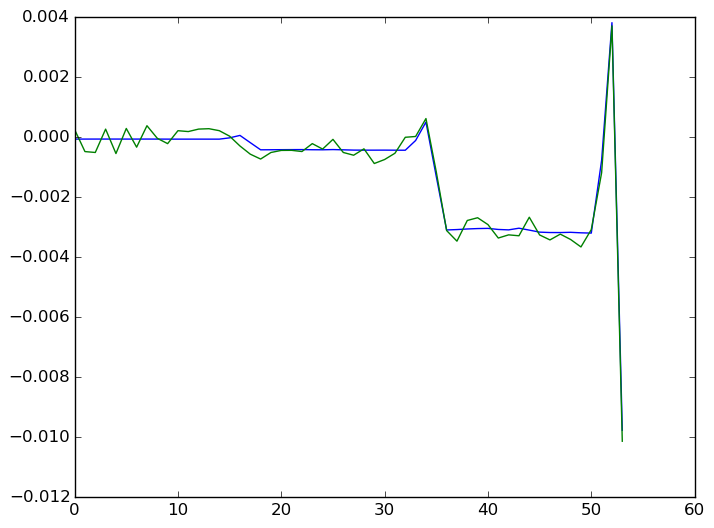

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4821fcca50>

In [157]:
plot(vecs[1])
hold=true
plot(vecs[1] + (rand(Nr*T) - 0.5)./1000)

In [240]:
find(score.==sort(score)[2])[1]

54

In [ ]:
T_approx(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
T0 = 46

# Compute final temperature with new method:
θij_vals = [θij1,θij2,θij3]
Tfinal1 = compute_T(int_length,a,c,f,time_intervals,θij_vals)

Tapprox = [T0]
T_0 = T0
for θij in θij_vals
    f_loss_pu = r_ij*(θij/x_ij)^2 # pu
    f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
    b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
    Tapprox = [Tapprox,T_approx(time_values,T_0,a,b)[2:end]]
    T_0 = Tapprox[end]
end

# Compare results of the two calculations:
# subplot(121)
plot(T738)
hold=true
plot(Tapprox)
scatter([30],[Tfinal1],c="green")
legend(["IEEE 738, dt=1s","Linear q_r","Temp. constraint"],loc=2,fontsize=9)
axis([0,31,Tamb,Tlim*1.25])
xlabel("Time (min)")
ylabel("Line temperature (C)")